There are some data issues in the training data. A file has been added to the Data page which contains the rows that should not be used due to data quality issues (2409 rows, with all features marked as NaN), as well as the rows where the pH and tm were transposed (25 rows, with corrected features in this dataset).

In [7]:
notation = '''Alanine (Ala, A)
Arginine (Arg, R)
Asparagine (Asn, N)
Aspartic acid (Asp, D)
Cysteine (Cys, C)
Glutamic acid (Glu, E)
Glutamine (Gln, Q)
Glycine (Gly, G)
Histidine (His, H)
Isoleucine (Ile, I)
Leucine (Leu, L)
Lysine (Lys, K)
Methionine (Met, M)
Phenylalanine (Phe, F)
Proline (Pro, P)
Serine (Ser, S)
Threonine (Thr, T)
Tryptophan (Trp, W)
Tyrosine (Tyr, Y)
Valine (Val, V)'''

protein_notation = notation.split('\n')

protein_dict = {}
for protein in protein_notation:
    letter = protein.split(',')[1].strip()[0] 
    word =  protein.split('(')[0].strip().lower()
    protein_dict[letter] = word

    
protein_dict2 = {}
for protein in protein_notation:
    letter = protein.split(',')[1].strip()[0] 
    word =  protein.split('(')[1].split(',')[0].strip().lower()
    protein_dict2[letter] = word

protein_dict, protein_dict2
    

({'A': 'alanine',
  'R': 'arginine',
  'N': 'asparagine',
  'D': 'aspartic acid',
  'C': 'cysteine',
  'E': 'glutamic acid',
  'Q': 'glutamine',
  'G': 'glycine',
  'H': 'histidine',
  'I': 'isoleucine',
  'L': 'leucine',
  'K': 'lysine',
  'M': 'methionine',
  'F': 'phenylalanine',
  'P': 'proline',
  'S': 'serine',
  'T': 'threonine',
  'W': 'tryptophan',
  'Y': 'tyrosine',
  'V': 'valine'},
 {'A': 'ala',
  'R': 'arg',
  'N': 'asn',
  'D': 'asp',
  'C': 'cys',
  'E': 'glu',
  'Q': 'gln',
  'G': 'gly',
  'H': 'his',
  'I': 'ile',
  'L': 'leu',
  'K': 'lys',
  'M': 'met',
  'F': 'phe',
  'P': 'pro',
  'S': 'ser',
  'T': 'thr',
  'W': 'trp',
  'Y': 'tyr',
  'V': 'val'})

In [2]:
import biopandas as bpd
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost


from biopandas.pdb import PandasPdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import spearmanr


In [3]:
df_train = pd.read_csv("./starting_folder/raw_data/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./starting_folder/raw_data/train_updates_20220929.csv", index_col="seq_id")
bio_df = PandasPdb().read_pdb('./starting_folder/raw_data/wildtype_structure_prediction_af2.pdb')

In [4]:
bio_df.df.keys()
df_atom = bio_df.df['ATOM']
#df_hetatm = bio_df.df['HETATM']
#df_anisou = bio_df.df['ANISOU']
df_others = bio_df.df['OTHERS']

In [5]:
df_others

,record_name,entry,line_idx
0,TER,3318 LYS A 221,3317
1,END,,3318


In [6]:
mega_protein_sequence = df_train.protein_sequence.sum()

In [7]:
mega_protein_sequence_series = pd.Series(list(mega_protein_sequence))
importance = mega_protein_sequence_series.value_counts()

In [8]:
all_letters = mega_protein_sequence_series.value_counts().index.to_list()

In [9]:
mega_protein_sequence_series_sample = pd.Series(list(df_train.sample(1000).protein_sequence.sum()))
mega_protein_sequence_series_sample.value_counts()

L    40151
A    33295
E    31361
S    30356
G    29021
V    27960
K    26451
T    23500
D    23479
R    22952
I    22490
P    21634
Q    18478
N    18165
F    15757
Y    12834
M    10042
H     9776
C     6507
W     4825
dtype: int64

In [10]:
df_train['ps_length'] = df_train.protein_sequence.apply(len)
df_train['ps_unique_length'] = df_train.protein_sequence.apply(lambda x: pd.Series(list(x)).nunique())

for letter in all_letters:
    df_train[letter] = df_train.protein_sequence.str.count(letter).astype('int')

In [11]:
df_train['initial_letter_importance'] = df_train.protein_sequence.apply(lambda x: importance[x[0]])

In [12]:
ps = df_train['protein_sequence'].iloc[2000]
ps

'IDLSLRRLHRAAFLFSRKKPETNLSTLFKPVQVHAYVDSEDVGSELSGKLEKAELLKILNKFTQRREIKSLCNENGLDDYLQQQAFGSFRRFCIEAENLPVDLHITFSDITQGAGHIDDIFPYFLRHAKTVFPHLDCMDDLKKISDLRQPANWYSNARAITRKIVFHAGPTNSGKTYHAMERYLSAKTGVYCGPLKLLATEVYNKANERGTPCDLVTGEERKFGISESLPANHVACTVEMTSVNTPYEVAVIDEIQQIRDPQRGWAWTRAFLGLIADEVHVCGEPGALDLLQKICETTGETVEVRLYDRLTELTVENTALGSLDNIVPGDCIVCFSKHDIYTVSREIEARGKEVAVIYGGLPPGTKLAQAAKFNDPANSCKVMVATDAIGMGLNLSIRRIIFYSLIKPSMNERGEREIDTISVSSALQIAGRAGRFRTQWEHGYVTAFKSEDLQTLQRILARTPEPIKQAGLHPTADQIELYAYHLPSSSLSNLMDIFVNLCTVDDSLYFMCNIEDFKFLAEMIQHVALPLRARYVFCCAPINRKMPFVCSMFLKVARQYSRNEPITFDFIKKNCGWPFKLPKTILDLVHLEAVFDVMDLYLWLSYRFMDLFPEAAYVRDAQKELDEIIQQGVFQITRLLKNTEASQDGETSNYAIRRITHVKEPRLPSLSRGRLTERLLAQGLLTPGMLSELRKEWDAQQLGKSNSQSNENSEPVVNSDDEDNYSGIGRKTRKKRR'

In [15]:
def generate_graph(protein_sequence):
    from_to_dict = {
        'from':list(protein_sequence[:-1]),
        'to':list(protein_sequence[1:])
    }
    protein_sequence_directions = pd.DataFrame(from_to_dict)
    list_of_paths = protein_sequence_directions.groupby('from').to.agg(list).values.tolist()
    G=nx.Graph()
    for path in list_of_paths:
        nx.add_path(G, path)
    return G
    
def flatten_result_dict(result_dictionary):
    index = []
    values = []
    for key in result_dictionary.keys():
        for letter in result_dictionary[key].keys():
            index.append(f'{key}_{letter}')
            values.append(result_dictionary[key][letter])
    df = pd.DataFrame(values, index=index).T
    return df 

def get_graph_results(graph):
    result_dictionary = {
        'degree_dict':dict(graph.degree()),
        'pagerank_dict': nx.pagerank(graph),
        #'centrality_eigenvector': nx.eigenvector_centrality(graph),
        'centrality_degree': nx.degree_centrality(graph),
        'centrality_closeness': nx.closeness_centrality(graph),
    }
    result_dictionary_df = flatten_result_dict(result_dictionary=result_dictionary)
    return result_dictionary_df

    
df_train['protein_graph'] = df_train['protein_sequence'].apply(generate_graph)
additional_df = df_train['protein_graph'].apply(get_graph_results)    

In [17]:
df_lists = []
for row in additional_df:
    df_lists.append(row)
graph_df = pd.concat(df_lists, ignore_index=True)

In [ ]:
new_df_train = pd.concat([df_train, graph_df], axis=1, ignore_index=True)

In [151]:
new_train = pd.concat([df_train,graph_df.set_index(df_train.index)], axis=1)

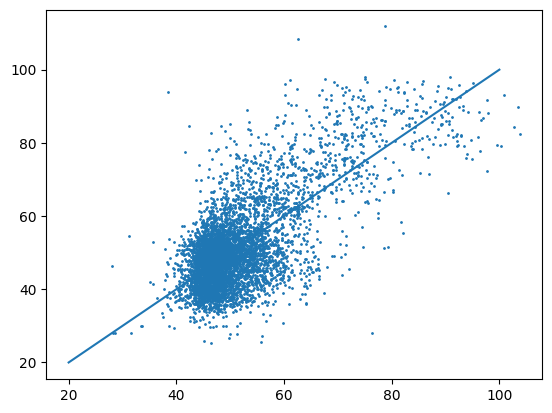

In [166]:
X = new_train.drop(columns = ['tm','protein_sequence', 'data_source', 'protein_graph', 'pH'])
y = new_train['tm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
model1 = xgboost.XGBRegressor(n_estimators=500, max_depth=3)
model1.fit(X_train, y_train)
predictions1 = model1.predict(X_test)

plt.scatter(predictions1, y_test, s=1)
plt.plot([20,100], [20,100],)

In [163]:
print('Mean Absolute Error =', mean_absolute_error(y_test, predictions1))
print('Mean Absolute Percentage Error = ', mean_absolute_percentage_error(y_test, predictions1))

rho, p = spearmanr(y_test, predictions1)
print('Spearman Correlation Coefficient =', rho.round(3))

Mean Absolute Error = 5.417803429373859
Mean Absolute Percentage Error =  0.07852142759541217
Spearman Correlation Coefficient = 0.735


pagerank_dict_N           0.096924
centrality_degree_Q       0.053169
R                         0.037058
pagerank_dict_C           0.033695
pagerank_dict_Q           0.032574
                            ...   
degree_dict_C             0.002610
centrality_closeness_P    0.002440
centrality_closeness_D    0.002211
degree_dict_K             0.001840
degree_dict_S             0.001665
Length: 104, dtype: float32

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


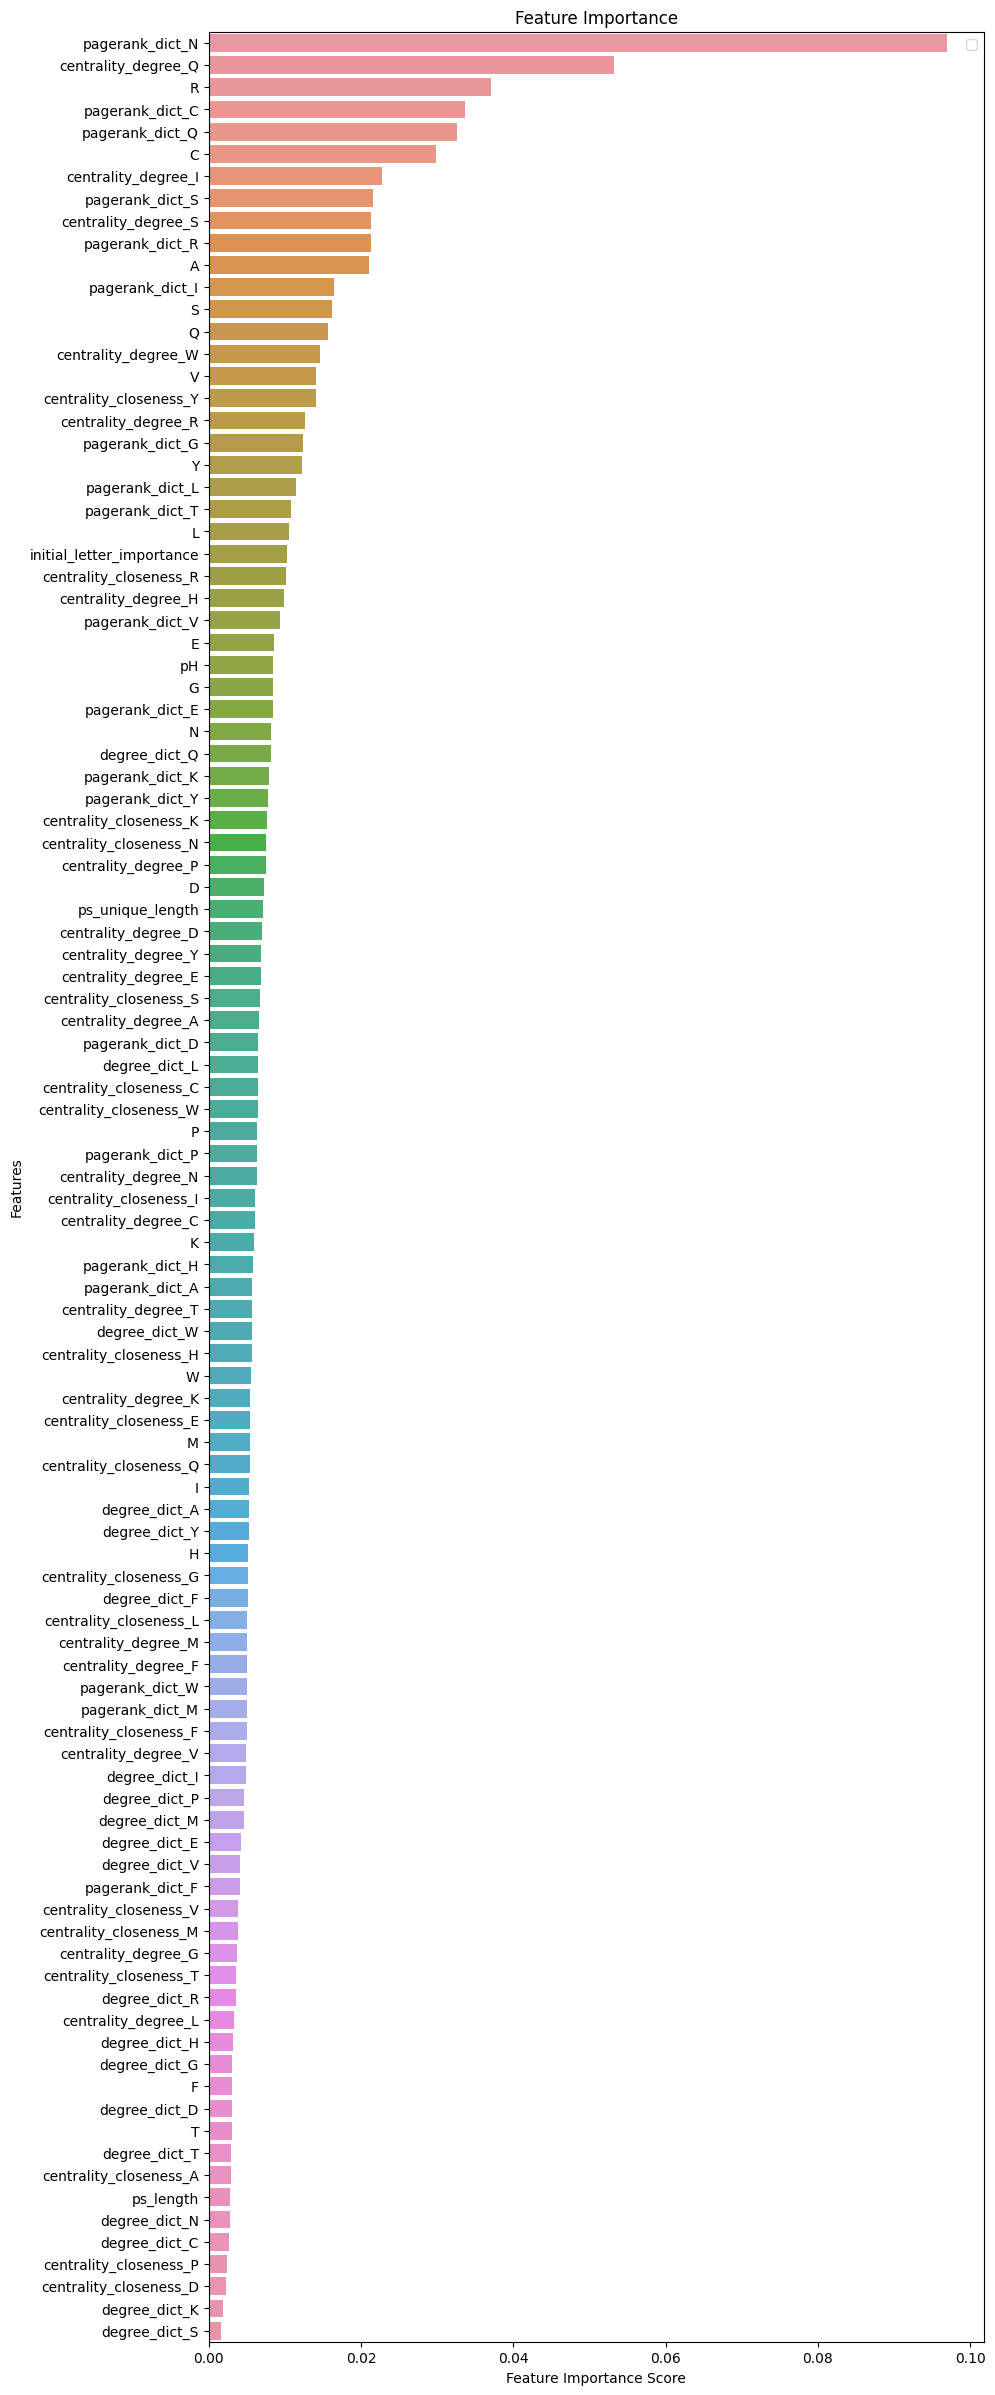

In [165]:
feature_imp = pd.Series(model1.feature_importances_,index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,30))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.legend()
plt.show()